# Predicting Subscription Churn 

**Task**: Analyze churn rate for a subscription-based personal finance business.

Churn rate is defined as the proportion of members who cancel their subscription. A 20% churn rate can also be referred to as an 80% retention rate.

**Goals**: 
* Calculate average churn rate over the last 9 months for each price tier.
* Predict the number of currently active subscriptions that will still be active next month.
* Predict the number of currently active subscriptions that will still be active in 3 months.
* Build a separate model that predicts tenure based on price tier, source, and country.
* Provide actionable insights to the business.

**Data**:

The data is in one table called 9mo_pull.csv. It contains data for all members who subscribed to a personal finance SaaS exactly 9 months ago. It does not contain data for members who subscribed since then. In other words, each member in the dataset has the same start date.

**Data Dictionary**:

member_id - Unique ID of the user.  
tier - Price tier (Silver, Gold, or Platinum).  
country - Member country.  
source - Original acquisition channel.  
tenure - Number of cycles billed. Min is 1. Max is 9.  
active - Is the subscription still active?  

In [50]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
sns.set_style("darkgrid")

In [51]:
df = pd.read_csv('9mo_pull.csv')

## Exploratory Data Analysis

In [52]:
df.shape

(99944, 6)

In [53]:
df.describe()

,member_id,tenure,active
count,9.994400e+04,99944.000000,99944.000000
mean,4.997105e+07,2.569229,0.074962
std,2.880743e+07,2.453557,0.263331
min,6.290000e+02,1.000000,0.000000
25%,2.498473e+07,1.000000,0.000000
50%,4.999141e+07,1.000000,0.000000
75%,7.476738e+07,3.000000,0.000000
max,9.999681e+07,9.000000,1.000000


In [54]:
df.isnull().sum()

member_id    0
tier         0
country      0
source       0
tenure       0
active       0
dtype: int64

In [55]:
df.head(10)

,member_id,tier,country,source,tenure,active
0,12428284,Platinum,Germany,referral,6,0
1,39743027,Platinum,France,referral,1,0
2,59559187,Silver,UK,organic,1,0
3,46170183,Silver,UK,organic,4,0
4,14600427,Gold,France,organic,1,0
5,66414091,Silver,Germany,organic,1,0
6,624565,Gold,Germany,referral,8,0
7,79845424,Platinum,Netherlands,organic,1,0
8,65813196,Gold,US,referral,9,1
9,33783639,Silver,US,organic,1,0


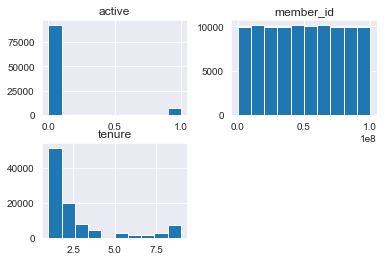

In [56]:
df.hist()
plt.show()

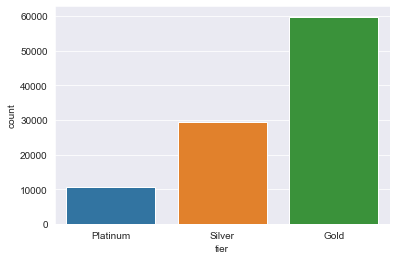

In [57]:
sns.countplot(x='tier',data=df)
plt.show()

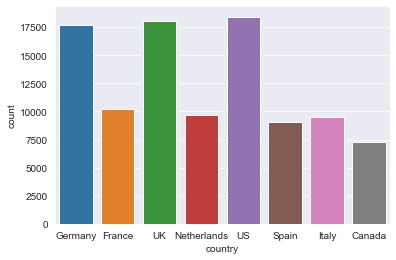

In [58]:
sns.countplot(x='country',data=df)
plt.show()

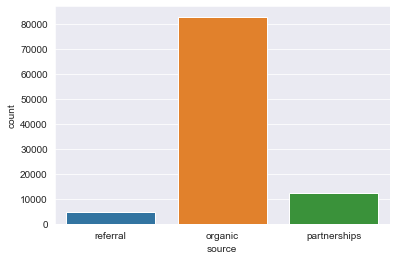

In [59]:
sns.countplot(x='source',data=df)
plt.show()

## Churn Rate Analysis

In [60]:
def churn_rate_plots(segment_by):
    """Convenience function for plotting segmented churn rates"""
    # Initialize sub-plots for 2 columns
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(14,6))
    
    # On the left, plot the distribution
    sns.countplot(x=segment_by, data=df, ax=ax1)
    
    # On the right, plot the retention rate
    sns.barplot(x=segment_by, y='active', data=df, ax=ax2)

    # Set title
    plt.suptitle('Retention Rate by {}'.format(segment_by.capitalize()))
    plt.show()

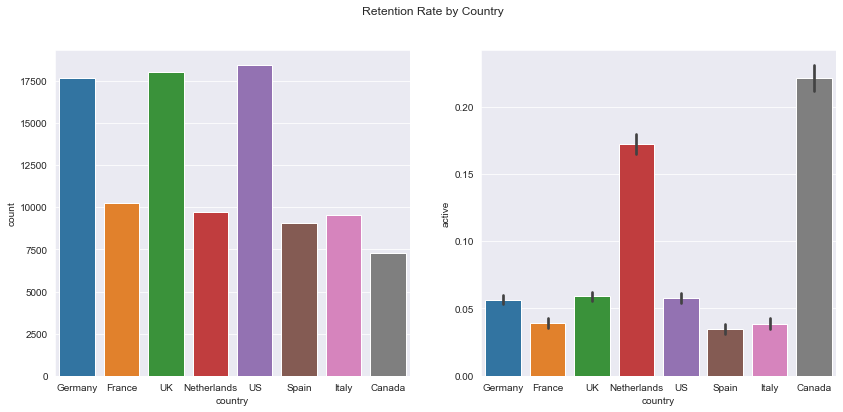

In [61]:
churn_rate_plots('country')

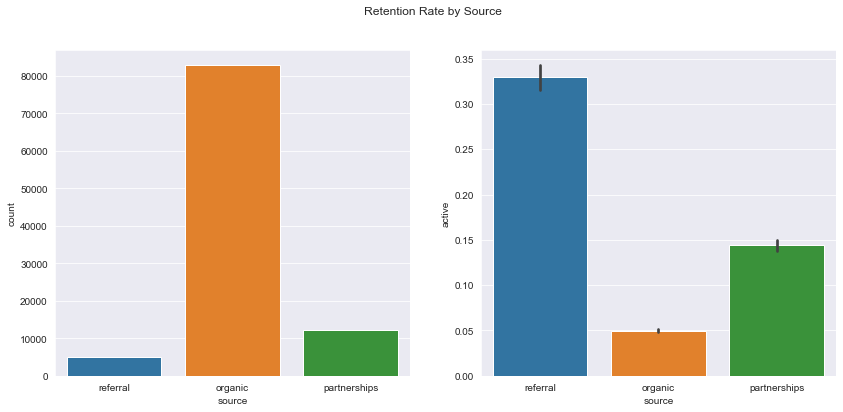

In [62]:
churn_rate_plots('source')

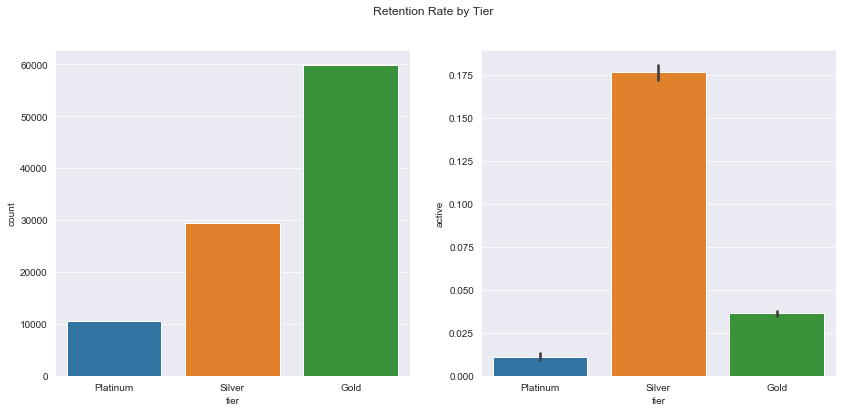

In [63]:
churn_rate_plots('tier')

In [64]:
1 - df.groupby(['tier'])['active'].mean()  #Churn Rate by Tier over 9 Months

tier
Gold        0.963735
Platinum    0.988809
Silver      0.823460
Name: active, dtype: float64

In [65]:
df.groupby(['tier'])['tenure'].mean() #Average Tenure by Tier

tier
Gold        2.135716
Platinum    1.474704
Silver      3.844327
Name: tenure, dtype: float64

In [66]:
df_monthly_summary = df.groupby(['tier','tenure'])['member_id'].count().reset_index()

In [67]:
tier_summary = df.groupby(['tier'])['member_id'].count().reset_index()

In [68]:
merged_df = pd.merge(df_monthly_summary,tier_summary,on='tier')

In [69]:
merged_df.head()

,tier,tenure,member_id_x,member_id_y
0,Gold,1,33147,59838
1,Gold,2,13255,59838
2,Gold,3,5002,59838
3,Gold,4,2460,59838
4,Gold,5,1413,59838


In [70]:
merged_df['churn_rate'] = (merged_df.member_id_x / merged_df.member_id_y)

In [71]:
merged_df

,tier,tenure,member_id_x,member_id_y,churn_rate
0,Gold,1,33147,59838,0.553946
1,Gold,2,13255,59838,0.221515
2,Gold,3,5002,59838,0.083592
3,Gold,4,2460,59838,0.041111
4,Gold,5,1413,59838,0.023614
5,Gold,6,877,59838,0.014656
6,Gold,7,675,59838,0.011280
7,Gold,8,839,59838,0.014021
8,Gold,9,2170,59838,0.036265
9,Platinum,1,8003,10634,0.752586


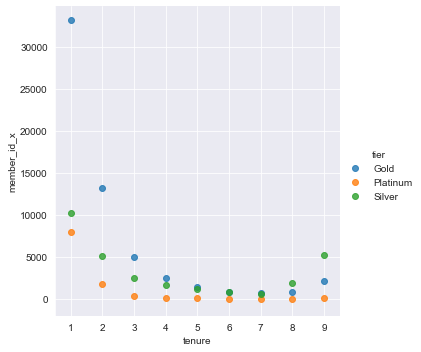

In [72]:
sns.lmplot(x="tenure", y="member_id_x", hue="tier",
               truncate=True, height=5, data=merged_df,fit_reg=False)
plt.show()

## Insights
* Retention rates are much higher in Canada & the Netherlands.

* Referral enrollments have a much higher retention rate. 

* Gold level enrollees are churning at approximately 1% every month for the last few months. This trend is exected to continue.

* Platinum level enrollees are churning between .2 - 1% every month for the last few months. This trend is expected to continue, with loss of nearly all remaining enrollees.

* Silver enrollees have the lowest churn rate, averaging over 17% after 9 months. However, current churn is higher around 3 - 6%. This trend is expected to continue. 

## Survival Analysis

Let's experiment with some survival analysis methods. We will mainly draw upon the scikit-survival package for analysis, but a similar process could be followed using the lifelines package.

In [73]:
#Lets experiment with some survival analysis methods
import sklearn
from sklearn.model_selection import train_test_split
from sksurv import column
#import graphviz

In [74]:
X = df[['source','country','tier']]

#Convert active to churn:
df['churn'] = np.where(df['active'] == 1, False ,True)
y = df[['churn','tenure']]

In [75]:
X.head()

,source,country,tier
0,referral,Germany,Platinum
1,referral,France,Platinum
2,organic,UK,Silver
3,organic,UK,Silver
4,organic,France,Gold


In [76]:
y.head()

,churn,tenure
0,True,6
1,True,1
2,True,1
3,True,4
4,True,1


In [77]:
n_censored = y.shape[0] - y["churn"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

7.5% of records are censored


The estimated survival function can be estimated by the kaplan-meier estimator. 

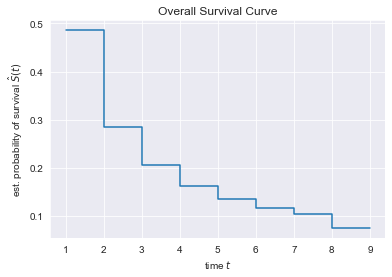

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y["churn"], y["tenure"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Overall Survival Curve")
plt.show()

Let's look at the survival curves for the three factors in our data set: tier, lead source, and country

Gold        48000
Silver      23482
Platinum     8473
Name: tier, dtype: int64


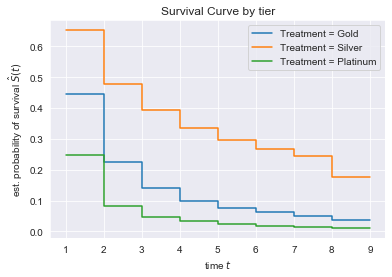

In [79]:
print(X_train["tier"].value_counts())

def survival_curves(X, y, feature):
    for feature_types in X[feature].value_counts().index:
        mask_treat = X[feature] == feature_types
        time_feature, survival_prob_treatment = kaplan_meier_estimator(
            y["churn"][mask_treat],
            y["tenure"][mask_treat])
    
        plt.step(time_feature, survival_prob_treatment, where="post",
                 label="Treatment = %s" % feature_types)

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.title("Survival Curve by {}".format(feature))
    plt.legend(loc="best")
    plt.show()
    
survival_curves(X,y,"tier")

organic         82836
partnerships    12200
referral         4908
Name: source, dtype: int64


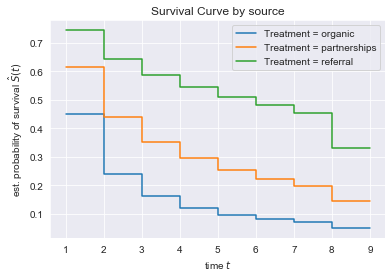

In [80]:
print(X["source"].value_counts())
survival_curves(X,y,"source")

US             18425
UK             18033
Germany        17689
France         10235
Netherlands     9693
Italy           9528
Spain           9048
Canada          7293
Name: country, dtype: int64


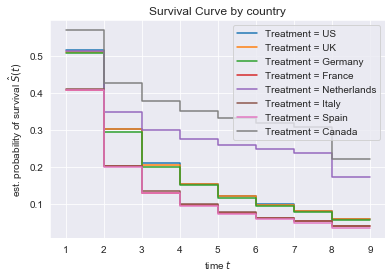

In [81]:
print(X["country"].value_counts())
survival_curves(X,y,"country")

The survival curves for the different tiers are substantially different, particularly for Silver tier customers, referral sources, and customers from the Netherlands and Canada.

Next, let's build a simple data processing and model pipeline with our data using a Cox Proportional Hazards Model.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2,random_state = 1234)

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis

pipe = Pipeline([('encode', OneHotEncoder()),
                 #('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [ ]:
pipe.fit(X_train,)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(data_x, data_y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [46]:
from sksurv.preprocessing import OneHotEncoder

X = X.astype("category")
X = OneHotEncoder().fit_transform(X)

y_churn = np.array(y.churn)
y_tenure = np.array(y.tenure)

y = y.to_records(index = False)

AttributeError: recarray has no attribute to_records

In [42]:
X.head()

,source=partnerships,source=referral,country=France,country=Germany,country=Italy,country=Netherlands,country=Spain,country=UK,country=US,tier=Platinum,tier=Silver
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X,y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [169]:
pd.Series(estimator.coef_, index=X.columns)

source=partnerships   -0.446493
source=referral       -1.036896
country=France         0.475021
country=Germany        0.252283
country=Italy          0.476636
country=Netherlands    0.106844
country=Spain          0.482669
country=UK             0.261939
country=US             0.261244
tier=Platinum          0.277911
tier=Silver           -0.565643
dtype: float64

In [165]:
x_new = pd.DataFrame.from_dict({
    1: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], #Partnership, Netherlands, Silver
    2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Organic, Canada, Gold
    3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], #Organic, Germany, Platinum
    4: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, #Referral, Canada, Silver
     columns=X.columns, orient='index')
x_new

,source=partnerships,source=referral,country=France,country=Germany,country=Italy,country=Netherlands,country=Spain,country=UK,country=US,tier=Platinum,tier=Silver
1,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,1


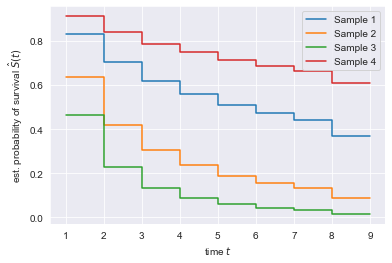

In [167]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

In [171]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X)
result = concordance_index_censored(y["churn"], y["tenure"], prediction)
result[0]

0.6786195163215728

In [172]:
estimator.score(X, y)

0.6786195163215728

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3,random_state = 1234)

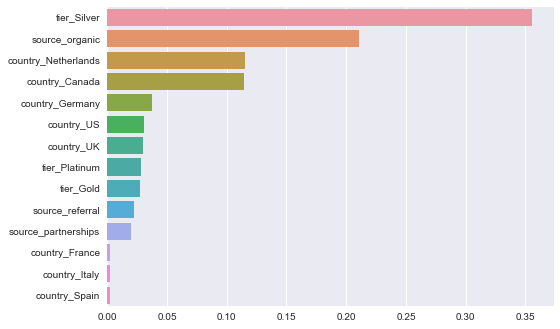

In [32]:
feature_importance = {X_test.columns[item] : rf_model.feature_importances_[item] for item in range(0,14)}
list_order = sorted(feature_importance,key=feature_importance.get,reverse=True)

sns.barplot([feature_importance[item] for item in list_order],list_order)
plt.show()

## Concluding Remarks

Random Forest and Decision Tree algorithms perform approximately the same on the test data, with an RMSE of approximately 1.55 months. There are a few variables of importance that stand out in the figure above, which confirm our understanding gained during EDA. The Silver tier is the most important feature for determining tenure, particularly longer tenure. Organic sourcing is also important, namely non-organic sourcing is best. Two countries, the Netherlands and Canada, have the longest tenure. Final recommendations include:
* Promotion of Silver Tier above others.
* Increase marketing in the Netherlands and Canada.
* Re-visit partnership agreements.
* Develop referral incentive to increase number of referrals. 


## Next Steps

Additional parameter tuning for the Random Forest algorithm may improve predictive accuracy.